### Bayesian Optimization for 2D retention model

In this notebook we will utilize the 2D retention model we set up in earlier noteboks and perform single and multi-task Bayesian optimization on it.

In [ ]:
from copy import deepcopy
import numpy as np
import pandas as pd
import time

from ax import OrderConstraint
from ax.core.observation import ObservationFeatures, observations_from_data
from ax.core.optimization_config import OptimizationConfig
from ax.core.search_space import SearchSpace
from ax.core.objective import Objective
from ax.runners.synthetic import SyntheticRunner
from ax.core.parameter import RangeParameter, ParameterType
from ax.core.multi_type_experiment import MultiTypeExperiment
from ax.modelbridge.factory import get_sobol, get_GPEI, get_MTGP
from ax.core.generator_run import GeneratorRun
from ax.plot.diagnostic import interact_batch_comparison
from ax.utils.notebook.plotting import init_notebook_plotting, render
from ax.metrics.noisy_function import NoisyFunctionMetric
from ax.core.arm import Arm

import torch

from rm_code.retention_model import online_system, offline_system

from utils.utils import bo_to_rm_2D

init_notebook_plotting()

[INFO 10-17 11:36:11] ax.utils.notebook.plotting: Injecting Plotly library into cell. Do not overwrite or delete cell.


In [14]:
# Set some default parameters for first dimension
t_0_1D = 4.5 # dead time
t_D_1D = 0.1 # dwell time
N_1D = 400 # plate number 1D
t_init_1D = 2 # init time

# create dictionary for the above described parameters
settings_1D = {'t_0': t_0_1D, 't_D': t_D_1D, 'N': N_1D, 't_init': t_init_1D}

### Set up a 2D retention model

### Define 2D parameters
# lower bounds of shifting gradients are named "init". upper bounds of shifting gradients aer named "final".
# time points of each shift have to be same in the current setup. Shift starts after the dead time of the first dimension. Shift ends at the end of the 1D program
# each gradient in the second dimension has a dead time, gradient time and modulation time.

N_2D = 1000 # plate number 2D

t_M_2D = 2 #/ 3 # modulation time minutes
t_G_2D = 1.8 #/ 3 # gradient time minutes
t_init_2D = 0.1 #/ 3 # init time minutes
t_D_2D = 0.01 # dwell time in minutes
t_0_2D = 0.01 # dead time in minutes

# create dictionary for the above described parameters
settings_2D = {'t_M': t_M_2D, 't_G': t_G_2D, 't_init': t_init_2D, 't_D': t_D_2D, 't_0': t_0_2D, 'N': N_2D}

# maximum allowed times in first and second dimension
max_T = [100, t_M_2D]

# Load the retention parameters created in "samplin_retention_paremters.ipynb"
ret_pars = pd.read_csv('data/2Dsample.csv').to_dict(orient='list')

n_analytes = len(ret_pars['k0_1D'])
print(n_analytes)

186


In [15]:
# Set some fixed parameters
t_max = 100 # maximum time
phi_min, phi_max = 0, 1 # maximum phi
fixed_phi_pars_1D = torch.tensor([[phi_min], [phi_max]]) # fixed phi points
fixed_time_pars_1D = torch.tensor([[0.], [t_max]]) # at fixed time points

fixed_phi_pars_2D = torch.tensor([[phi_min], [phi_max]]) # fixed phi points
fixed_time_pars_2D = torch.tensor([[0.],[t_0_1D], [t_max]]) # at fixed time points

# We will optimize 12 parameters, 4 parameters (2 gradient turning points) in the first dimension.
# And 8 parameters in the second dimension, two time points, and three phi_init and phi_final point of the shifting gradient.
# Pars vector will look like this: [phi1, phi2, t1, t2, phi_i1, phi_i2, phi_i3, phi_f1, phi_f2, phi_f3, t1_shift, t2_shift]
# bounds = torch.stack([
#     torch.tensor([phi_min, phi_min, 0.1, 0.1, phi_min, phi_min, phi_min, phi_min, phi_min, phi_min, t_0_1D, t_0_1D]),
#     torch.tensor([phi_max, phi_max, t_max-0.1, t_max-0.1, phi_max, phi_max, phi_max, phi_max, phi_max, phi_max, t_max-t_M_2D, t_max-t_M_2D])]
# )

# bounds after normalization to [0,1]
norm_bounds = torch.stack([torch.zeros(12), torch.ones(12)])

# We will also need to set some inequality constraints : 1. phi_i1 < phi_f2, 2. phi_i2 < phi_f3,
# 3. t1 < t2, 4. phi1 < phi2,  5. -t1_shift + t2_shift > tM
# Spare representation of BoTorch.
# ([indices of parameters], [coefficients], constant), example: ((torch.tensor([0,1]), torch.tensor([-1., 1.]), 0.0)) -x0 + x1 >= 0
# inequality_constraints= [(torch.tensor([0,1]), torch.tensor([-1., 1.]), torch.tensor(0.0)), (torch.tensor([2,3]), torch.tensor([-1., 1.]), torch.tensor(0.1)), (torch.tensor([10,11]), torch.tensor([-1., 1.]), torch.tensor(t_M_2D)), (torch.tensor([4,8]), torch.tensor([-1., 1.]), torch.tensor(0.0)), (torch.tensor([5,9]), torch.tensor([-1., 1.]), torch.tensor(0.0))]

# draw 10 random indices between 0 and n_analytes
remove_indices = np.random.randint(0, n_analytes, 30)
# create dictionary with noise levels
noise = {'tR_1D': 2, 'tR_2D': 0.3, 'W_1D': 0.2, 'W_2D': 0.05}

### Define metrics

We will define two metrics, one for the online and one for the offline system.

In [16]:
class OnlineMetric(NoisyFunctionMetric):
    def f(self, x: np.ndarray) -> float:        # turn x into a torch tensor and add a dimension
        x = torch.tensor(x).unsqueeze(0)
        phi_list_1D, t_list_1D, phi_init_2D, phi_final_2D, t_list_2D = bo_to_rm_2D(x, fixed_phi_pars_1D, fixed_time_pars_1D, fixed_phi_pars_2D, fixed_time_pars_2D)
        tR_list_1D, W_list_1D, tR_list_2D, W_list_2D, res_score, time_score = online_system(ret_pars, settings_1D, settings_2D, phi_list_1D[0], t_list_1D[0], phi_init_2D[0], phi_final_2D[0], t_list_2D[0], max_T)
        # if res_score or time_score is nan, return 0
        if np.isnan(res_score) or np.isnan(time_score):
            print('res_score or time_score is nan')
            return 0
        else:
            return res_score #- time_score

class OfflineMetric(NoisyFunctionMetric):
    def f(self, x:np.ndarray) -> float:
        x = torch.tensor(x).unsqueeze(0)
        phi_list_1D, t_list_1D, phi_init_2D, phi_final_2D, t_list_2D = bo_to_rm_2D(x, fixed_phi_pars_1D, fixed_time_pars_1D, fixed_phi_pars_2D, fixed_time_pars_2D)
        tR_list_1D, W_list_1D, tR_list_2D, W_list_2D, res_score, time_score = offline_system(ret_pars, settings_1D, settings_2D, phi_list_1D[0], t_list_1D[0],phi_init_2D[0], phi_final_2D[0], t_list_2D[0], max_T, noise, remove_indices)

        if np.isnan(res_score) or np.isnan(time_score):
            print('res_score or time_score is nan')
            return 0
        else:
            return res_score #- time_score

### Define experiment

We will define an experiment with two trial types, online and offline. The online trial type will be run on the online system, and the offline trial type will be run on the offline system. In addition, we here introduce the parameters and their bounds and constraints.

In [17]:
def get_experiment(include_true_metric=True):
    noise_sd = 1  # Observations will have this much Normal noise added to them

    # 1. Create simple search space for [0,1]^d, d=6
    param_names = [f"x{i}" for i in range(12)]
    print(param_names)
    parameters=[
        RangeParameter( # phi_1
            name=param_names[0], parameter_type=ParameterType.FLOAT, lower=0.1, upper=1.0
        ),
        RangeParameter( # phi_2
            name=param_names[1], parameter_type=ParameterType.FLOAT, lower=0.1, upper=1.0
        ),
        RangeParameter( # t_1
            name=param_names[2], parameter_type=ParameterType.FLOAT, lower=0.1, upper=t_max-0.2
        ),
        RangeParameter( # t_2
            name=param_names[3], parameter_type=ParameterType.FLOAT, lower=0.2, upper=t_max-0.1
        ),
        RangeParameter( # phi_init_1
            name=param_names[4], parameter_type=ParameterType.FLOAT, lower=0.1, upper=1.0
        ),
        RangeParameter( # phi_init_2
            name=param_names[5], parameter_type=ParameterType.FLOAT, lower=0.1, upper=1.0
        ),
        RangeParameter( # phi_init_3
            name=param_names[6], parameter_type=ParameterType.FLOAT, lower=0.1, upper=1.0
        ),
        RangeParameter( # phi_final_1
            name=param_names[7], parameter_type=ParameterType.FLOAT, lower=0.1, upper=1.0
        ),
        RangeParameter( # phi_final_2
            name=param_names[8], parameter_type=ParameterType.FLOAT, lower=0.1, upper=1.0
        ),
        RangeParameter( # phi_final_3
            name=param_names[9], parameter_type=ParameterType.FLOAT, lower=0.1, upper=1.0
        ),
        RangeParameter( # t_1_shift
            name=param_names[10], parameter_type=ParameterType.FLOAT, lower=t_0_1D, upper=t_max-t_M_2D-0.1
        ),
        RangeParameter( # t_2_shift
            name=param_names[11], parameter_type=ParameterType.FLOAT, lower=t_0_1D+0.1, upper=t_max-t_M_2D
        )
    ]
    search_space = SearchSpace(parameters=parameters)
    constraints = [
        OrderConstraint(
            lower_parameter=search_space.parameters['x0'],
            upper_parameter=search_space.parameters['x1'],

        ),
        OrderConstraint(
            lower_parameter=search_space.parameters['x2'],
            upper_parameter=search_space.parameters['x3'],
        ),
        OrderConstraint(
            lower_parameter=search_space.parameters['x10'],
            upper_parameter=search_space.parameters['x11'],
        ),
        OrderConstraint(
            lower_parameter=search_space.parameters['x4'],
            upper_parameter=search_space.parameters['x8'],
        ),
        OrderConstraint(
            lower_parameter=search_space.parameters['x5'],
            upper_parameter=search_space.parameters['x9'],
        ),
    ]
    search_space=SearchSpace(parameters=parameters, parameter_constraints=constraints)

    # 2. Specify optimization config
    online_objective = OnlineMetric("objective", param_names=param_names, noise_sd=noise_sd)
    opt_config = OptimizationConfig(objective=Objective(online_objective, minimize=False))

    # 3. Init experiment
    exp = MultiTypeExperiment(
        name="mt_exp",
        search_space=search_space,
        default_trial_type="online",
        default_runner=SyntheticRunner(),
        optimization_config=opt_config,
    )

    # 4. Establish offline trial_type, and how those trials are deployed
    exp.add_trial_type("offline", SyntheticRunner())

    # 5. Add offline metrics that provide biased estimates of the online metrics
    offline_objective = OfflineMetric("offline_objective", param_names=param_names, noise_sd=noise_sd)
    # Associate each offline metric with corresponding online metric
    exp.add_tracking_metric(metric=offline_objective, trial_type="offline", canonical_name="objective")

    return exp

In [19]:
# Settings for the optimization benchmark.

# This should be changed to 50 to reproduce the results from the paper.
n_reps = 10  # Number of repeated experiments, each with independent observation noise

n_init_online = 5  # Size of the quasirandom initialization run online
n_init_offline = 30  # Size of the quasirandom initialization run offline
n_opt_online = 1  # Batch size for BO selected points to be run online
n_opt_offline = 4  # Batch size for BO selected to be run offline
n_batches = 20  # Number of optimized BO batches

# Create gr_scanning a Generator with 4 points that I can define myself
# gr_scanning = GeneratorRun(arms=[
#     Arm(parameters={'x0': 0.55, 'x1': 1.0, 'x2': 20, 'x3': 40.0, 'x4': 0.1, 'x5': 0.1, 'x6': 0.1, 'x7': 1.0, 'x8': 1.0, 'x9': 1.0, 'x10': 20, 'x11': 40}),
#     Arm(parameters={'x0': 0.55, 'x1': 1.0, 'x2': 30, 'x3': 60.0, 'x4': 0.1, 'x5': 0.1, 'x6': 0.1, 'x7': 1.0, 'x8': 1.0, 'x9': 1.0, 'x10': 20, 'x11': 40}),
#     Arm(parameters={'x0': 0.55, 'x1': 1.0, 'x2': 40, 'x3': 80.0, 'x4': 0.1, 'x5': 0.1, 'x6': 0.1, 'x7': 1.0, 'x8': 1.0, 'x9': 1.0, 'x10': 20, 'x11': 40}),
#     Arm(parameters={'x0': 0.55, 'x1': 1.0, 'x2': 45, 'x3': 90.0, 'x4': 0.1, 'x5': 0.1, 'x6': 0.1, 'x7': 1.0, 'x8': 1.0, 'x9': 1.0, 'x10': 20, 'x11': 40})], weights=[1.0]*4)


In [21]:
# This function runs a Bayesian optimization loop, making online observations only.
def run_online_only_bo(trial):
    t1 = time.time()
    ### Do BO with online only
    ## Quasi-random initialization
    exp_online = get_experiment()
    m = get_sobol(exp_online.search_space, seed=trial, scramble=True, fallback_to_sample_polytope=True)
    gr = m.gen(n=n_init_online)
    exp_online.new_batch_trial(trial_type="online", generator_run=gr).run()
    # run gr_scanning
    # exp_online.new_batch_trial(trial_type="online", generator_run=gr_scanning).run()
    #print('Done running online scannings')
    ## Do BO
    for b in range(n_batches):
        print('Online-only batch', b, time.time() - t1)
        # Fit the GP
        m = get_GPEI(
            experiment=exp_online,
            data=exp_online.fetch_data(),
            search_space=exp_online.search_space,
        )
        # Generate the new batch
        gr = m.gen(
            n=n_opt_online,
            search_space=exp_online.search_space,
            optimization_config=exp_online.optimization_config,
        )
        exp_online.new_batch_trial(trial_type="online", generator_run=gr).run()
    return exp_online

In [22]:
# Online batches are constructed by selecting the maximum utility points from the offline
# batch, after updating the model with the offline results. This function selects the max utility points according
# to the MTGP predictions.
def max_utility_from_GP(n, m, experiment, search_space, gr):
    obsf = []
    for arm in gr.arms:
        params = deepcopy(arm.parameters)
        params['trial_type'] = 'online'
        obsf.append(ObservationFeatures(parameters=params))
    # Make predictions
    f, cov = m.predict(obsf)
    # Compute expected utility
    u = -np.array(f['objective'])
    best_arm_indx = np.flip(np.argsort(u))[:n]
    gr_new = GeneratorRun(
        arms = [
            gr.arms[i] for i in best_arm_indx
        ],
        weights = [1.] * n,
    )
    return gr_new

# This function runs a Multi-Task Bayesian optimization loop, as outlined in Algorithm 1 and above.
def run_mtbo(trial):
    t1 = time.time()
    online_trials = []
    ## 1. Quasi-random initialization, online and offline
    exp_multitask = get_experiment()
    # Online points
    m = get_sobol(exp_multitask.search_space, seed=trial, scramble=True, fallback_to_sample_polytope=True)
    gr = m.gen(
        n=n_init_online,
    )
    # print('running online scans')
    tr = exp_multitask.new_batch_trial(trial_type="online", generator_run=gr)
    tr.run()
    online_trials.append(tr.index)

    # also run gr_scanning offline
    #print('running offline scans')
    #exp_multitask.new_batch_trial(trial_type="offline", generator_run=gr_scanning).run()

    # print('running additional offline exps')
    # # Offline points
    m = get_sobol(exp_multitask.search_space, scramble=True, fallback_to_sample_polytope=True)
    gr = m.gen(
        n=n_init_offline,
    )
    exp_multitask.new_batch_trial(trial_type="offline", generator_run=gr).run()
    ## Do BO
    for b in range(n_batches):
        print('Multi-task batch', b, time.time() - t1)
        # (2 / 7). Fit the MTGP
        m = get_MTGP(
            experiment=exp_multitask,
            data=exp_multitask.fetch_data(),
            search_space=exp_multitask.search_space,
            #fit_out_of_design=True,
        )

        # 3. Finding the best points for the online task
        gr = m.gen(
            n=n_opt_offline,
            optimization_config=exp_multitask.optimization_config,
            fixed_features=ObservationFeatures(parameters={}, trial_index=online_trials[-1]),
        )

        # 4. But launch them offline
        exp_multitask.new_batch_trial(trial_type="offline", generator_run=gr).run()

        # 5. Update the model
        m = get_MTGP(
            experiment=exp_multitask,
            data=exp_multitask.fetch_data(),
            search_space=exp_multitask.search_space,
            #fit_out_of_design=True,
        )

        # 6. Select max-utility points from the offline batch to generate an online batch
        gr = max_utility_from_GP(
            n=n_opt_online,
            m=m,
            experiment=exp_multitask,
            search_space=exp_multitask.search_space,
            gr=gr,
        )
        tr = exp_multitask.new_batch_trial(trial_type="online", generator_run=gr)
        tr.run()
        online_trials.append(tr.index)
    return exp_multitask

### Run the experiment

We will run the experiment for 8 repetitions, and save the results to a csv file.

Note that this will take a long time to run, and it is recommended to run this on a cluster. Change the settings above to run a smaller experiment.

In [23]:
runners = {
    'GP, online only': run_online_only_bo,
    'MTGP': run_mtbo,
}

for rep in range(n_reps):
    print('Running rep', rep)
    for k, r in runners.items():
        print('Running', k)
        exp = r(rep)
        df = exp.fetch_data().df
        # add a rep column
        df['rep'] = rep
        # add a runner column
        df['runner'] = k
        # depending on the runner add to a dataframe check if first rep and what runner
        if rep == 0 and k == 'GP, online only':
            res = df
        elif rep == 0 and k == 'MTGP':
            res_mtbo = df
        elif rep > 0 and k == 'GP, online only':
            res = pd.concat([res, df])
        elif rep > 0 and k == 'MTGP':
            res_mtbo = pd.concat([res_mtbo, df])
        else:
            raise ValueError('Something went wrong')


Running rep 0
Running GP, online only
['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11']
Online-only batch 0 0.05185198783874512
Online-only batch 1 10.770642042160034
Online-only batch 2 23.721633911132812
Online-only batch 3 35.91934394836426
Online-only batch 4 46.98802614212036
Online-only batch 5 62.72356915473938
Online-only batch 6 81.00109505653381
Online-only batch 7 109.34885597229004
Online-only batch 8 129.49730706214905
Online-only batch 9 146.73082995414734
Online-only batch 10 161.14352989196777
Online-only batch 11 176.0196990966797
Online-only batch 12 190.63542103767395
Online-only batch 13 206.1418080329895
Online-only batch 14 224.40309810638428
Online-only batch 15 241.08153009414673
Online-only batch 16 255.8026430606842
Online-only batch 17 270.62884187698364
Online-only batch 18 288.6507959365845
Online-only batch 19 305.6534719467163
Running MTGP
['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11']
Multi-task batch 

KeyboardInterrupt: 

In [42]:
# write to csv
# res.to_csv('data/res_online_correct.csv')
# res_mtbo.to_csv('data/res_mtbo_correct.csv')

In [25]:
# read from csv
res = pd.read_csv('data/res.csv')
res_mtbo = pd.read_csv('data/res_mtbo.csv')

In [26]:
res

,Unnamed: 0,arm_name,metric_name,mean,sem,trial_index,n,frac_nonnull,rep,runner
0,0,0_0,objective,49.062127,1.0,0,2000,49.062127,0,"GP, online only"
1,1,0_1,objective,58.102973,1.0,0,2000,58.102973,0,"GP, online only"
2,2,0_2,objective,33.790839,1.0,0,2000,33.790839,0,"GP, online only"
3,3,0_3,objective,36.462959,1.0,0,2000,36.462959,0,"GP, online only"
4,4,0_4,objective,43.157140,1.0,0,2000,43.157140,0,"GP, online only"
...,...,...,...,...,...,...,...,...,...,...
245,20,16_0,objective,112.832866,1.0,16,10000,112.832866,9,"GP, online only"
246,21,17_0,objective,110.479418,1.0,17,10000,110.479418,9,"GP, online only"
247,22,18_0,objective,109.430078,1.0,18,10000,109.430078,9,"GP, online only"
248,23,19_0,objective,110.679795,1.0,19,10000,110.679795,9,"GP, online only"


0
1
2
3
4
5
6
7


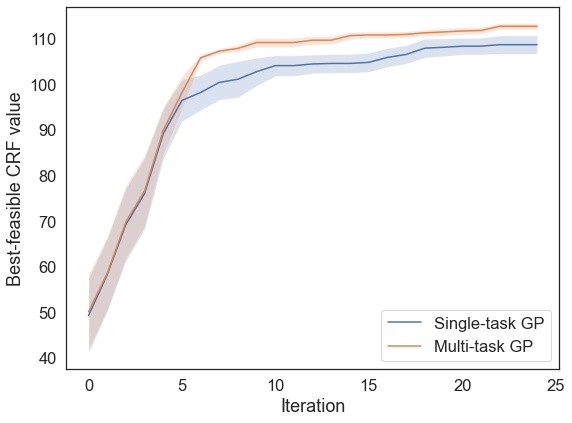

In [28]:
means = []
means_mtgp = []
n_reps = 8
n_reps = np.arange(8)

for i in n_reps:
    print(i)
    means.append(res[(res['metric_name'] == 'objective') & (res['rep'] == i)]['mean'].values)
    means_mtgp.append(res_mtbo[(res_mtbo['metric_name'] == 'objective') & (res_mtbo['rep'] == i)]['mean'].values)

means = np.array(means)
means_mtgp = np.array(means_mtgp)

def get_best_so_far(means):
    for i in range(len(n_reps)):
        for j in range(len(means[i])):
            if j == 0:
                continue
            else:
                means[i][j] = max(means[i][j], means[i][j-1])
    return means

means = get_best_so_far(means)
means_mtgp = get_best_so_far(means_mtgp)

# now take the mean over axis 0
means_mean = np.mean(means, axis=0)
means_mtgp_mean = np.mean(means_mtgp, axis=0)

# take std over axis 0
stds = np.std(means, axis=0) / np.sqrt(len(n_reps))
stds_mtgp = np.std(means_mtgp, axis=0) / np.sqrt(len(n_reps))

# now plot the means and stds using matplotlib and fill_between
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style('white')
# now plot the means and stds using matplotlib and fill_between
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plt.tight_layout()
ax.plot(np.arange(len(means_mean)), means_mean, label='Single-task GP')
ax.plot(np.arange(len(means_mtgp_mean)), means_mtgp_mean, label='Multi-task GP')
ax.fill_between(np.arange(len(means_mean)), means_mean - stds, means_mean + stds, alpha=0.2)
ax.fill_between(np.arange(len(means_mtgp_mean)), means_mtgp_mean - stds_mtgp, means_mtgp_mean + stds_mtgp, alpha=0.2)
ax.set_xlabel('Iteration')
ax.set_ylabel('Best-feasible CRF value')
#ax.set_ylim(100, 130)
ax.legend()

# save figure
# plt.savefig('figures/bo_vs_mtbo_realsample.png', dpi=500, bbox_inches='tight')
# plt.savefig('figures/bo_vs_mtbo_realsample.pdf', dpi=500, bbox_inches='tight')

